In [172]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
STARTING_BB_01 = (800, 60, 140, 60) #підібрано вручну
STARTING_BB_02 = (955, 80, 175, 80) #підібрано вручну
FOLDER = "lab_04_videos/"
VIDEO_01 = FOLDER + "/skiing_01.mp4"
VIDEO_02 = FOLDER + "/skiing_02.mp4"

OF + KCF

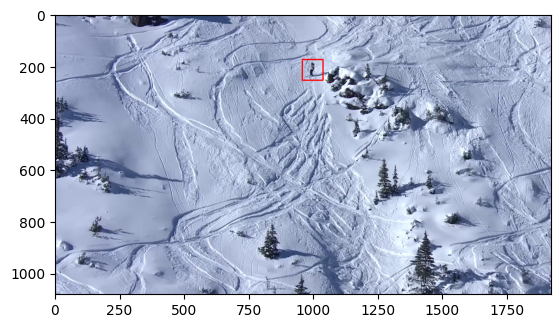

In [206]:
cap = cv2.VideoCapture(VIDEO_02)
ret, frame = cap.read()

roi_x, roi_h, roi_y, roi_w = STARTING_BB_02 
track_window = (roi_x, roi_y, roi_w, roi_h)
roi = frame[roi_x:roi_x+roi_h, roi_y:roi_y+roi_w]
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.rectangle(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (roi_x,roi_y), (roi_x+roi_h, roi_y+roi_w), color=(255,0,0), thickness=3))

term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

tracker_kcf = cv2.TrackerKCF_create()
tracker_kcf.init(frame, track_window)

In [ ]:
#oF points init
old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w], mask=None, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
p0[:,0,0] += roi_x
p0[:,0,1] += roi_y

#FOR SAVING VIDEO
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(FOLDER + 'tracking_02_vKCF_OF.mp4', fourcc, 30.0, (frame.shape[1], frame.shape[0]))

frame_idx = 1

previous_bbox = None

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    #OF
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if len(p0) > 0:
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, p0, None, winSize=(15,15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
        good_new = p1[st==1]
        good_old = p0[st==1]
        dx = np.mean(good_new[:,0] - good_old[:,0])
        dy = np.mean(good_new[:,1] - good_old[:,1])
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            cv2.line(frame, (int(a),int(b)), (int(c),int(d)), (0,255,255), 2)
            cv2.circle(frame, (int(a),int(b)), 3, (0,255,255), -1)
        p0 = good_new.reshape(-1,1,2)
    old_gray = gray.copy()

    #KCF is blue
    success_kcf, bbox_kcf = tracker_kcf.update(frame)
    if success_kcf:
        print()
        x,y,w,h = [int(v) for v in bbox_kcf]
        x_new = int(x + dx)
        y_new = int(y + dy)
        bbox_kcf = (x_new, y_new, w, h) # (roi_x, roi_y, roi_w, roi_h)
        previous_bbox = bbox_kcf
        cv2.rectangle(frame,(x_new,y_new),(x_new+w,y_new+h),(255,0,0),2)
    else:
        x,y,w,h = [int(v) for v in previous_bbox]
        x_new = int(x + dx)
        y_new = int(y + dy)
        previous_bbox = (x_new, y_new, w, h)
        tracker_kcf = cv2.TrackerKCF_create()
        tracker_kcf.init(frame, previous_bbox)
        cv2.rectangle(frame,(x_new,y_new),(x_new+w,y_new+h),(255,0,0),2)

        #re-detecting of points every few frames
        if frame_idx % 10 == 0:
            p0 = cv2.goodFeaturesToTrack(gray[y:y+h, x:x+w], maxCorners=100, qualityLevel=0.3, minDistance=7)
            if p0 is None:
                print('kcf out of bounds')
                break
            p0[:,0,0] += x
            p0[:,0,1] += y

    cv2.imshow('Tracking', cv2.resize(frame, (960, 540)))
    out.write(frame)

    if cv2.waitKey(30) & 0xFF == 27:
        break
    frame_idx += 1
    
out.release()
cap.release()
cv2.destroyAllWindows()































































































































kcf out of bounds


CSRT

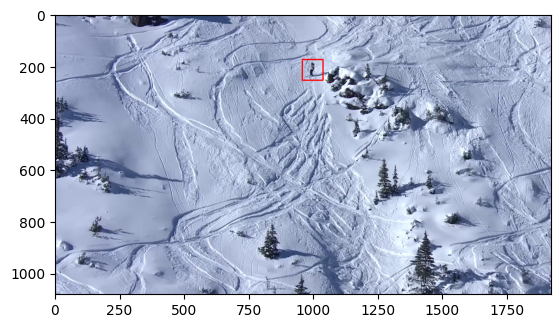

In [202]:
cap = cv2.VideoCapture(VIDEO_02)
ret, frame = cap.read()

roi_x, roi_h, roi_y, roi_w = STARTING_BB_02
#track_window = (roi_x, roi_y, roi_w, roi_h)
#roi = frame[roi_x:roi_x+roi_h, roi_y:roi_y+roi_w]
plt.imshow(cv2.rectangle(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (roi_x,roi_y), (roi_x+roi_h, roi_y+roi_w), color=(255,0,0), thickness=3))

In [ ]:
track_window = (roi_x, roi_y, roi_w, roi_h)
roi = frame[roi_x:roi_x+roi_h, roi_y:roi_y+roi_w]

tracker_csrt = cv2.TrackerCSRT_create()
tracker_csrt.init(frame, track_window)

#FOR SAVING VIDEO
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(FOLDER + 'tracking_02_vCSRT.mp4', fourcc, 30.0, (frame.shape[1], frame.shape[0]))

frame_idx = 1

while True:
    ret, frame = cap.read()
    if not ret:
        break

    success_csrt, bbox_csrt = tracker_csrt.update(frame)
    if success_csrt:
        x,y,w,h = [int(v) for v in bbox_csrt]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)

    cv2.imshow('Tracking', cv2.resize(frame, (960, 540)))
    out.write(frame)

    if cv2.waitKey(30) & 0xFF == 27:
        break
    frame_idx += 1
    
out.release()
cap.release()
cv2.destroyAllWindows()


MOSSE

In [ ]:
cap = cv2.VideoCapture(VIDEO_02)
ret, frame = cap.read()

roi_x, roi_h, roi_y, roi_w = STARTING_BB_02
track_window = (roi_x, roi_y, roi_w, roi_h)
roi = frame[roi_x:roi_x+roi_h, roi_y:roi_y+roi_w]

tracker_mosse = cv2.legacy.TrackerMOSSE_create()
tracker_mosse.init(frame, track_window)

#FOR SAVING VIDEO
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(FOLDER + 'tracking_02_vMOSSE.mp4', fourcc, 30.0, (frame.shape[1], frame.shape[0]))

frame_idx = 1

while True:
    ret, frame = cap.read()
    if not ret:
        break

    success_mosse, bbox_mosse = tracker_mosse.update(frame)
    if success_mosse:
        x,y,w,h = [int(v) for v in bbox_mosse]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

    cv2.imshow('Tracking', cv2.resize(frame, (960, 540)))
    out.write(frame)

    if cv2.waitKey(30) & 0xFF == 27:
        break
    frame_idx += 1

out.release()
cap.release()
cv2.destroyAllWindows()


KCF

In [ ]:
cap = cv2.VideoCapture(VIDEO_01)
ret, frame = cap.read()

roi_x, roi_h, roi_y, roi_w = STARTING_BB_01
track_window = (roi_x, roi_y, roi_w, roi_h)
roi = frame[roi_x:roi_x+roi_h, roi_y:roi_y+roi_w]

tracker_kcf = cv2.TrackerKCF_create()
tracker_kcf.init(frame, track_window)

#FOR SAVING VIDEO
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(FOLDER + 'tracking_01_vKCF.mp4', fourcc, 30.0, (frame.shape[1], frame.shape[0]))

frame_idx = 1

while True:
    ret, frame = cap.read()
    if not ret:
        break

    success_kcf, bbox_kcf = tracker_kcf.update(frame)
    if success_kcf:
        previous_bbox = bbox_kcf
        x,y,w,h = [int(v) for v in bbox_kcf]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    else:
        x,y,w,h = [int(v) for v in previous_bbox]
        tracker_kcf = cv2.TrackerKCF_create()
        tracker_kcf.init(frame, previous_bbox)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

    cv2.imshow('Tracking', cv2.resize(frame, (960, 540)))
    out.write(frame)

    if cv2.waitKey(30) & 0xFF == 27:
        break
    frame_idx += 1

out.release()
cap.release()
cv2.destroyAllWindows()
